# 📈 Évaluation du Modèle CIFAR-10

**Projet Deep Learning - Classification d'Images**

**Étudiant**: Ahmed Belhareth

**Module**: Deep Learning - Computer Vision

---

Ce notebook évalue les performances du modèle entraîné sur CIFAR-10.

## 1. Configuration

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)
from tqdm.auto import tqdm  # auto détecte notebook vs console
import json

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [2]:
# Configuration
CLASSES = [
    'Avion', 'Automobile', 'Oiseau', 'Chat', 'Cerf',
    'Chien', 'Grenouille', 'Cheval', 'Navire', 'Camion'
]
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2470, 0.2435, 0.2616]
BATCH_SIZE = 128

## 2. Chargement du Modèle

In [3]:
class CIFAR10ResNet(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=10, dropout_rate=0.2):
        super().__init__()
        if model_name == 'resnet18':
            self.backbone = models.resnet18(weights=None)
        elif model_name == 'resnet34':
            self.backbone = models.resnet34(weights=None)
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, num_classes)
        )
        self.model_name = model_name
        self.num_classes = num_classes
    
    def forward(self, x):
        return self.backbone(x)

# Charger le checkpoint
checkpoint_path = './best_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Récupérer la configuration
config = checkpoint.get('config', {'model_name': 'resnet18', 'dropout_rate': 0.2})

# Créer et charger le modèle
model = CIFAR10ResNet(
    model_name=config.get('model_name', 'resnet18'),
    num_classes=10,
    dropout_rate=config.get('dropout_rate', 0.2)
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Modèle chargé depuis: {checkpoint_path}")
print(f"Époque du checkpoint: {checkpoint.get('epoch', 'N/A')}")
print(f"Accuracy validation: {checkpoint.get('val_acc', 'N/A'):.2f}%")

Modèle chargé depuis: ./best_model.pth
Époque du checkpoint: 26
Accuracy validation: 86.22%


## 3. Chargement des Données de Test

In [4]:
# Transformations de test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD)
])

# Charger le dataset de test
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Note: num_workers=0 pour compatibilité Windows
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

print(f"Taille du dataset de test: {len(test_dataset)}")
print(f"Nombre de batches: {len(test_loader)}")

Taille du dataset de test: 10000
Nombre de batches: 79


## 4. Évaluation sur le Dataset de Test

In [5]:
def evaluate_model(model, loader, device):
    """Évalue le modèle et retourne les prédictions."""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Évaluation"):
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets), np.array(all_probs)

# Évaluer
y_pred, y_true, y_probs = evaluate_model(model, test_loader, device)

print(f"\nÉvaluation terminée sur {len(y_true)} échantillons")

Évaluation:   0%|          | 0/79 [00:00<?, ?it/s]


Évaluation terminée sur 10000 échantillons


## 5. Métriques de Performance

In [6]:
# Calculer les métriques
accuracy = accuracy_score(y_true, y_pred) * 100
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

# Top-5 accuracy
top5_correct = 0
for i, probs in enumerate(y_probs):
    top5_preds = np.argsort(probs)[-5:]
    if y_true[i] in top5_preds:
        top5_correct += 1
top5_accuracy = top5_correct / len(y_true) * 100

print("="*50)
print("MÉTRIQUES DE PERFORMANCE")
print("="*50)
print(f"\n📊 Accuracy Top-1: {accuracy:.2f}%")
print(f"📊 Accuracy Top-5: {top5_accuracy:.2f}%")
print(f"\n📈 F1-Score (macro): {f1_macro:.4f}")
print(f"📈 F1-Score (weighted): {f1_weighted:.4f}")
print(f"📈 Précision (macro): {precision_macro:.4f}")
print(f"📈 Rappel (macro): {recall_macro:.4f}")

MÉTRIQUES DE PERFORMANCE

📊 Accuracy Top-1: 87.09%
📊 Accuracy Top-5: 99.46%

📈 F1-Score (macro): 0.8705
📈 F1-Score (weighted): 0.8705
📈 Précision (macro): 0.8705
📈 Rappel (macro): 0.8709


In [7]:
# Rapport de classification détaillé
print("\n" + "="*50)
print("RAPPORT DE CLASSIFICATION PAR CLASSE")
print("="*50 + "\n")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))


RAPPORT DE CLASSIFICATION PAR CLASSE

              precision    recall  f1-score   support

       Avion     0.8979    0.8880    0.8929      1000
  Automobile     0.9279    0.9260    0.9269      1000
      Oiseau     0.8592    0.8420    0.8505      1000
        Chat     0.7516    0.7080    0.7291      1000
        Cerf     0.8555    0.8940    0.8743      1000
       Chien     0.7780    0.7920    0.7849      1000
  Grenouille     0.8857    0.9220    0.9035      1000
      Cheval     0.9219    0.8850    0.9031      1000
      Navire     0.9301    0.9310    0.9305      1000
      Camion     0.8977    0.9210    0.9092      1000

    accuracy                         0.8709     10000
   macro avg     0.8705    0.8709    0.8705     10000
weighted avg     0.8705    0.8709    0.8705     10000



## 6. Matrice de Confusion

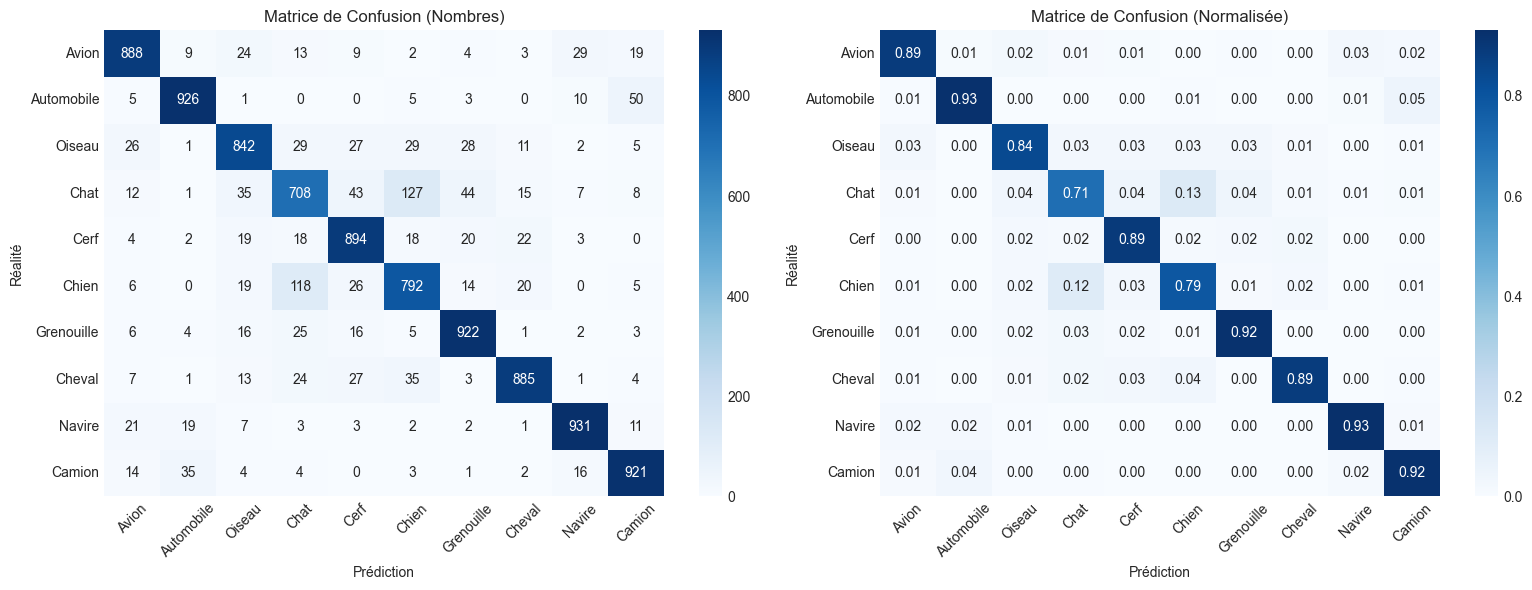

In [8]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice brute
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
axes[0].set_title('Matrice de Confusion (Nombres)', fontsize=12)
axes[0].set_xlabel('Prédiction')
axes[0].set_ylabel('Réalité')
axes[0].tick_params(axis='x', rotation=45)

# Matrice normalisée
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
axes[1].set_title('Matrice de Confusion (Normalisée)', fontsize=12)
axes[1].set_xlabel('Prédiction')
axes[1].set_ylabel('Réalité')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Analyse des Erreurs

In [9]:
# Identifier les paires de classes les plus confondues
confusions = []
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        if i != j and cm[i, j] > 0:
            confusions.append({
                'vraie_classe': CLASSES[i],
                'predite_comme': CLASSES[j],
                'nombre': cm[i, j],
                'pourcentage': cm_normalized[i, j] * 100
            })

# Trier par nombre d'erreurs
confusions = sorted(confusions, key=lambda x: x['nombre'], reverse=True)

print("Top 10 des confusions les plus fréquentes:")
print("-" * 60)
for conf in confusions[:10]:
    print(f"{conf['vraie_classe']:12} → {conf['predite_comme']:12}: "
          f"{conf['nombre']:4} erreurs ({conf['pourcentage']:.1f}%)")

Top 10 des confusions les plus fréquentes:
------------------------------------------------------------
Chat         → Chien       :  127 erreurs (12.7%)
Chien        → Chat        :  118 erreurs (11.8%)
Automobile   → Camion      :   50 erreurs (5.0%)
Chat         → Grenouille  :   44 erreurs (4.4%)
Chat         → Cerf        :   43 erreurs (4.3%)
Chat         → Oiseau      :   35 erreurs (3.5%)
Cheval       → Chien       :   35 erreurs (3.5%)
Camion       → Automobile  :   35 erreurs (3.5%)
Avion        → Navire      :   29 erreurs (2.9%)
Oiseau       → Chat        :   29 erreurs (2.9%)


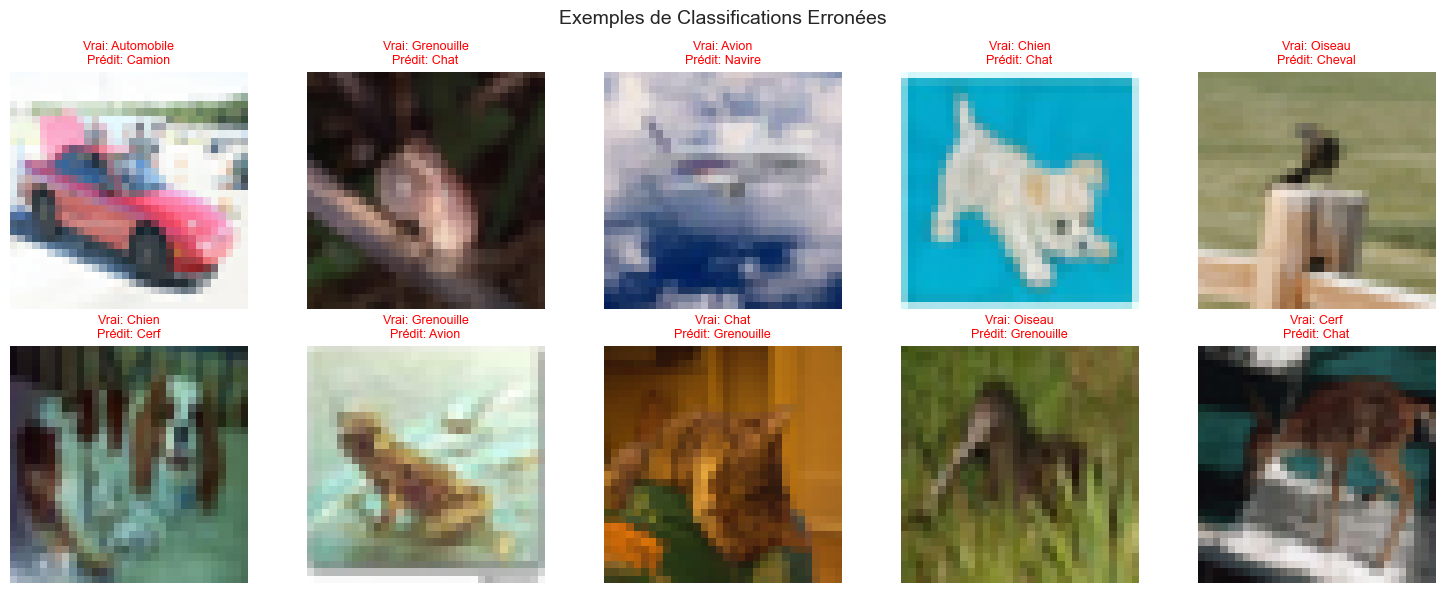

In [10]:
# Visualiser des exemples d'erreurs
def show_misclassified(dataset, y_true, y_pred, num_examples=10):
    """Affiche des exemples mal classifiés."""
    # Trouver les indices des erreurs
    errors = np.where(y_true != y_pred)[0]
    
    # Sélectionner aléatoirement
    selected = np.random.choice(errors, min(num_examples, len(errors)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(selected):
        img, _ = dataset[idx]
        # Dénormaliser
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array(CIFAR10_STD) + np.array(CIFAR10_MEAN)
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Vrai: {CLASSES[y_true[idx]]}\nPrédit: {CLASSES[y_pred[idx]]}",
                         fontsize=9, color='red')
        axes[i].axis('off')
    
    plt.suptitle('Exemples de Classifications Erronées', fontsize=14)
    plt.tight_layout()
    plt.savefig('erreurs_classification.png', dpi=150)
    plt.show()

show_misclassified(test_dataset, y_true, y_pred)

## 8. Métriques par Classe

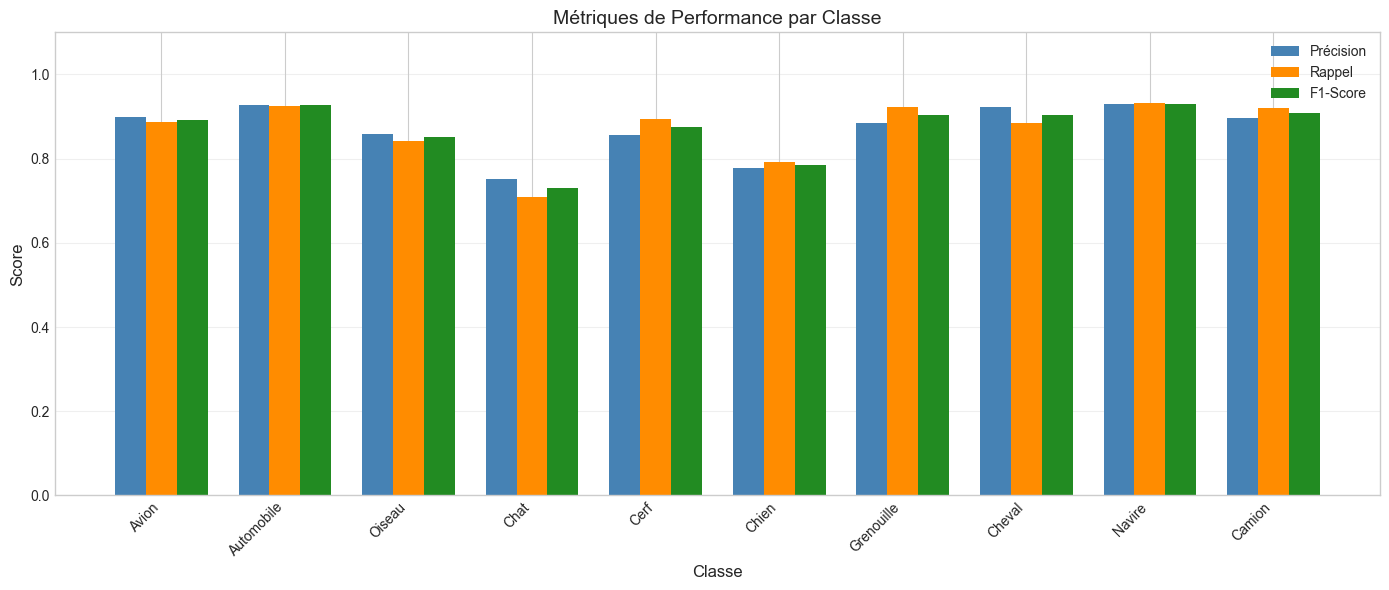

In [11]:
# Calculer les métriques par classe
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# Visualiser
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(CLASSES))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Précision', color='steelblue')
bars2 = ax.bar(x, recall_per_class, width, label='Rappel', color='darkorange')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='forestgreen')

ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Métriques de Performance par Classe', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('metriques_par_classe.png', dpi=150)
plt.show()

## 9. Sauvegarde des Résultats

In [12]:
# Créer un résumé des résultats
results = {
    'metriques_globales': {
        'accuracy_top1': float(accuracy),
        'accuracy_top5': float(top5_accuracy),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro)
    },
    'metriques_par_classe': {
        classe: {
            'precision': float(precision_per_class[i]),
            'recall': float(recall_per_class[i]),
            'f1_score': float(f1_per_class[i])
        }
        for i, classe in enumerate(CLASSES)
    },
    'top_confusions': [
        {k: (int(v) if isinstance(v, (np.integer, np.int64)) else float(v) if isinstance(v, (np.floating, np.float64)) else v) 
         for k, v in conf.items()}
        for conf in confusions[:10]
    ],
    'nombre_erreurs': int(np.sum(y_true != y_pred)),
    'nombre_correct': int(np.sum(y_true == y_pred))
}

# Sauvegarder
with open('evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("Résultats sauvegardés dans 'evaluation_results.json'")

Résultats sauvegardés dans 'evaluation_results.json'


## 10. Conclusions

### Résumé des performances

Le modèle ResNet-18 fine-tuné atteint les performances suivantes sur le dataset de test CIFAR-10:

| Métrique | Valeur |
|----------|--------|
| Accuracy Top-1 | voir ci-dessus |
| Accuracy Top-5 | voir ci-dessus |
| F1-Score Macro | voir ci-dessus |

### Points forts
- Utilisation du transfer learning
- Augmentation de données efficace
- Régularisation par dropout

### Pistes d'amélioration
- Essayer d'autres architectures (EfficientNet, Vision Transformer)
- Augmenter les données avec MixUp/CutMix
- Optimiser les hyperparamètres avec recherche bayésienne

In [13]:
print("\n" + "="*50)
print("ÉVALUATION TERMINÉE")
print("="*50)
print(f"\nFichiers générés:")
print("  - confusion_matrix.png")
print("  - erreurs_classification.png")
print("  - metriques_par_classe.png")
print("  - evaluation_results.json")


ÉVALUATION TERMINÉE

Fichiers générés:
  - confusion_matrix.png
  - erreurs_classification.png
  - metriques_par_classe.png
  - evaluation_results.json
